# Cassava Leaf Disease Classification
> Identify the type of disease present on Cassava Leaf image

- toc: true
- badges: true
- categories: [plant,disease,classification,tfrecord,efficientnet]


# Overview

This notebook is a simple training pipeline in TensorFlow for the [Cassava Leaf Competition](https://www.kaggle.com/c/cassava-leaf-disease-classification) where we are given `21,397` labeled images of cassava leaves classified as 5 different groups (4 diseases and a healthy group) and asked to predict on unseen images of cassava leaves. As with most image classification problems, we can use and experiment with many different forms of augmentation and we can explore transfer learning. 

# Prework

In [1]:
#hide
%%writefile conditional_cell_extension.py
def run_if(line, cell=None):
    '''Execute current line/cell if line evaluates to True.'''
    if not eval(line):
        return
    get_ipython().ex(cell)

def load_ipython_extension(shell):
    '''Registers the run_if magic when the extension loads.'''
    shell.register_magic_function(run_if, 'line_cell')

def unload_ipython_extension(shell):
    '''Unregisters the run_if magic when the extension unloads.'''
    del shell.magics_manager.magics['cell']['run_if']

Overwriting conditional_cell_extension.py


In [2]:
#hide
%reload_ext conditional_cell_extension

> Note:  I am using [Dimitre](https://www.kaggle.com/dimitreoliveira)'s TFRecords that can be found [here](https://www.kaggle.com/dimitreoliveira/cassava-leaf-disease-tfrecords-512x512). He also has 128x128, 256x256, and 384x384 sized images that I added for experimental purposes. Please give his datasets an upvote (and his work in general, it is excellent).

In [3]:
#collapse-hide
import numpy as np
import pandas as pd
import seaborn as sns
import albumentations as A
import matplotlib.pyplot as plt
import os, gc, cv2, random, warnings
import re, math, sys, json, pprint, pdb
from functools import partial

import tensorflow as tf
from tensorflow.keras import backend as K
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split, KFold

warnings.simplefilter('ignore')
print(f"Using TensorFlow v{tf.__version__}")

Using TensorFlow v2.4.1


In [4]:
#hide
#@title Accelerator type { run: "auto", display-mode: "form" }
DEVICE = 'TPU' #@param ["None", "'GPU'", "'TPU'"] {type:"raw", allow-input: true}

if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTOTUNE = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Running on TPU  grpc://10.86.149.146:8470
initializing  TPU ...
INFO:tensorflow:Initializing the TPU system: grpc://10.86.149.146:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.86.149.146:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


TPU initialized
REPLICAS: 8


> Tip: Adding seed helps reproduce results. Setting debug parameter wil run the model on smaller number of epochs to validate the architecture.

In [5]:
#collapse-hide
#@title Notebook type { run: "auto", display-mode:"form" }
SEED = 10120919
DEBUG = False #@param {type:"boolean"}
TRAIN = True #@param {type:"boolean"}

def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

GOOGLE = 'google.colab' in str(get_ipython())
KAGGLE = not GOOGLE

seed_everything(SEED)

print("Running on {}!".format(
   "Google Colab" if GOOGLE else "Kaggle Kernel"
))

Running on Google Colab!


In [8]:
#hide
%%run_if {GOOGLE}
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [9]:
#hide
project_name = 'cassava-leaf-disease-classification'
root_path  = '/content/gdrive/MyDrive/' if GOOGLE else '/'
input_path = f'{root_path}kaggle/input/{project_name}/'
working_path = f'{input_path}working/' if GOOGLE else '/kaggle/working/'
os.makedirs(working_path, exist_ok=True)
os.chdir(working_path)
os.listdir(input_path)

['label_num_to_disease_map.json',
 'sample_submission.csv',
 'train.csv',
 'cassava-leaf-disease-classification.zip',
 'test_images',
 'test_tfrecords',
 'train_images',
 'train_tfrecords',
 'dump.tfcache.data-00000-of-00001',
 'dump.tfcache.index',
 'working']

# Hyperparameters

In [10]:
#hide-collapse
#@title {run: "auto", display-mode: "form" }

BASE_MODEL= 'efficientnet_b4' #@param ["'efficientnet_b3'", "'efficientnet_b4'", "'efficientnet_b2'"] {type:"raw", allow-input: true}
BATCH_SIZE =  16#@param {type:"raw"}
GLOBAL_BATCH_SIZE =  BATCH_SIZE * strategy.num_replicas_in_sync
HEIGHT = 512#@param {type:"number"}
WIDTH = 512#@param {type:"number"}
CHANNELS = 3#@param {type:"number"}
IMG_SIZE = (HEIGHT, WIDTH, CHANNELS)
EPOCHS =  10#@param {type:"number"}
NFOLDS = 5#@param {type:"number"}
print("Using {} with input size {}".format(BASE_MODEL, IMG_SIZE))

Using efficientnet_b4 with input size (512, 512, 3)


# Data

In [11]:
#hide-collapse
#https://www.kaggle.com/austinyhc/cassava-leaf-disease-training-with-tpu-v2-pods
#@title {run: "auto", display-mode: "form" }
# Center croped and resized (50 TFRecord)
GCS_PATH = 'gs://kds-9aecb18aed03b1f0cea34ca09091eb32987aa7540d8ac12c9f54c64f' #@param {}
# Center croped and resized (50 TFRecord) (External)
GCS_PATH_EXT = 'gs://kds-39493737465cc4c55b35ca04026ea11ead1b98214e5818fc773a1b5f' #@param {}
# Center croped and resized (50 TFRecord) by classes
GCS_PATH_CLASSES = 'gs://kds-11c08dd0f9f509cf61933721cdacccf3559eca504d37c4c378705637'#@param {}
# Center croped and resized (50 TFRecord) (External) by classes
GCS_PATH_EXT_CLASSES = 'gs://kds-9886c0721272cc49e5c67bfb0b6fab57325b7414795a1ed2d9c73bb8'#@param {}



In [12]:
#collapse-show
def count_data_items(filenames):
    return np.sum([int(re.compile(r'-([0-9]*)\.').search(filename).group(1))
            for filename in filenames])

## Exploring data

In [13]:
df = pd.read_csv(f'{input_path}train.csv')
df.head()

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

Check how many images are available in the training dataset and also check if each item in the training set are unique

In [14]:
#hide_input
print(f"Number of training images: {len(df)}")

Number of training images: 21397


The distribution of labels is obviously unbalanced as can be observed in the figure below.

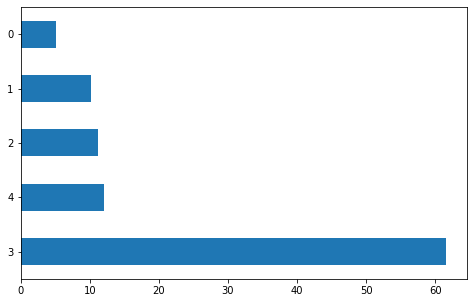

In [15]:
#hide_input
(df.label.value_counts(normalize=True) * 100).plot.barh(figsize = (8, 5))

Let's preprocess to add the directory string to the filename and rename the column to `filename`

In [16]:
df['filename'] = df['image_id'].map(lambda x : f'{input_path}train_images/{x}')
df = df.drop(columns = ['image_id'])
df = df.sample(frac=1).reset_index(drop=True)

In [17]:
df.head()

label                                           filename
0      3  /content/gdrive/MyDrive/kaggle/input/cassava-l...
1      2  /content/gdrive/MyDrive/kaggle/input/cassava-l...
2      3  /content/gdrive/MyDrive/kaggle/input/cassava-l...
3      4  /content/gdrive/MyDrive/kaggle/input/cassava-l...
4      3  /content/gdrive/MyDrive/kaggle/input/cassava-l...

Let's find out what labels do we have for the 5 categories.

In [18]:
#hide_input
with open(f'{input_path}label_num_to_disease_map.json') as file:
    id2label = json.loads(file.read())

NCLASSES = len(id2label)
id2label

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

## Loading data
After my quick and rough EDA, let's load the PIL Image to a Numpy array, so we can move on to data augmentation.

In fastai, they have `item_tfms` and `batch_tfms` defined for their data loader API. The item transforms performs a fairly large crop to 224 and also apply other standard augmentations (in aug_tranforms) at the batch level on the GPU. The batch size is set to 32 here.

Normally, the number of data in a tfrecord is given in the string of the tfrecord file name.

In [19]:
skf = KFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)
oof_pred, oof_labels, history_list = [],[],[]

In [20]:
train_ids, valid_ids = next(skf.split(np.arange(50)))

In [21]:
FILENAMES_COMP = tf.io.gfile.glob([GCS_PATH + '/Id_train%.2i*.tfrec' % x for x in train_ids])
FILENAMES_2019 = tf.io.gfile.glob([GCS_PATH_EXT + '/Id_train%.2i*.tfrec' % x for x in train_ids])

FILENAMES_COMP_CBB = tf.io.gfile.glob([GCS_PATH_CLASSES + '/CBB%.2i*.tfrec' % x for x in train_ids])
FILENAMES_COMP_CBSD = tf.io.gfile.glob([GCS_PATH_CLASSES + '/CBSD%.2i*.tfrec' % x for x in train_ids])
FILENAMES_COMP_CGM = tf.io.gfile.glob([GCS_PATH_CLASSES + '/CGM%.2i*.tfrec' % x for x in train_ids])

FILENAMES_2019_CBB = tf.io.gfile.glob([GCS_PATH_EXT_CLASSES + '/CBB%.2i*.tfrec' % x for x in train_ids])
FILENAMES_2019_CBSD = tf.io.gfile.glob([GCS_PATH_EXT_CLASSES + '/CBSD%.2i*.tfrec' % x for x in train_ids])
FILENAMES_2019_CGM = tf.io.gfile.glob([GCS_PATH_EXT_CLASSES + '/CGM%.2i*.tfrec' % x for x in train_ids])
FILENAMES_2019_Healthy = tf.io.gfile.glob([GCS_PATH_EXT_CLASSES + '/Healthy%.2i*.tfrec' % x for x in train_ids])

In [22]:
train_filenames = (FILENAMES_COMP + 
                   FILENAMES_2019 + 
                   (2 * FILENAMES_COMP_CBB) + 
                   (2 * FILENAMES_2019_CBB) + 
                   (2 * FILENAMES_COMP_CBSD) + 
                   (2 * FILENAMES_2019_CBSD) + 
                   (2 * FILENAMES_COMP_CGM) + 
                   (2 * FILENAMES_2019_CGM) + 
                   (2 * FILENAMES_2019_Healthy) + 
                   (2 * FILENAMES_2019_Healthy))
                   
valid_filenames = tf.io.gfile.glob(
    [GCS_PATH + '/Id_train%.2i*.tfrec' % x for x in valid_ids])

In [23]:
count_data_items(train_filenames), count_data_items(valid_filenames)

(31372, 4280)

## Data transformation

In this stage we will collating the data and the label, and then do some basic data transformation so the image size can fit to the input size of the model.

Basically item transformations mainly make sure the input data is of the same size so that it can be collated in batches.


In [24]:
#collapse-hide
def transform_shear(image, height, shear):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly sheared
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    shear = shear * tf.random.uniform([1],dtype='float32')
    shear = math.pi * shear / 180.
        
    # SHEAR MATRIX
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape(tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3])    

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shear_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

In [25]:
#collapse-hide
def transform_shift(image, height, h_shift, w_shift):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly shifted
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    height_shift = h_shift * tf.random.uniform([1],dtype='float32') 
    width_shift = w_shift * tf.random.uniform([1],dtype='float32') 
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
        
    # SHIFT MATRIX
    shift_matrix = tf.reshape(tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3])

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shift_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

In [26]:
#collapse-hide
def transform_rotation(image, height, rotation):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = rotation * tf.random.uniform([1],dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape(tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3])

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

In [27]:
#collapse-hide
def random_cutout(image, height, width, channels=3,
            min_mask_size=(10, 10), max_mask_size=(80, 80), k=1):
    assert height > min_mask_size[0]
    assert width > min_mask_size[1]
    assert height > max_mask_size[0]
    assert width > max_mask_size[1]

    for i in range(k):
        mask_height = tf.random.uniform(shape=[], minval=min_mask_size[0],
                                        maxval=max_mask_size[0], dtype=tf.int32)
        mask_width = tf.random.uniform(shape=[], minval=min_mask_size[1],
                                       maxval=max_mask_size[1], dtype=tf.int32)
        pad_h = height - mask_height
        pad_top = tf.random.uniform(shape=[], minval=0, maxval=pad_h, dtype=tf.int32)
        pad_bottom = pad_h - pad_top

        pad_w = width - mask_width
        pad_left = tf.random.uniform(shape=[], minval=0, maxval=pad_w, dtype=tf.int32)
        pad_right = pad_w - pad_left

        cutout_area = tf.zeros(shape=[mask_height, mask_width, channels], dtype=tf.uint8)

        cutout_mask = tf.pad([cutout_area], [[0,0],
                        [pad_top, pad_bottom], [pad_left, pad_right],
                        [0,0]], constant_values=1)
        cutout_mask = tf.squeeze(cutout_mask, axis=0)
        image = tf.multiply(tf.cast(image, tf.float32),
                            tf.cast(cutout_mask, tf.float32))
        return image

In [28]:
#collapse-hide
def data_augment_cutout(image, min_mask_size=(int(HEIGHT * .1), int(HEIGHT * .1)), 
                        max_mask_size=(int(HEIGHT * .125), int(HEIGHT * .125))):
    p_cutout = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    if p_cutout > .85: # 10~15 cut outs
        n_cutout = tf.random.uniform([], 10, 15, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .6: # 5~10 cut outs
        n_cutout = tf.random.uniform([], 5, 10, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .25: # 2~5 cut outs
        n_cutout = tf.random.uniform([], 2, 5, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    else: # 1 cut out
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=1)
    return image

In [29]:
#collapse-show
def data_augment(image, label):
    p_rotation = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_shear = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_cutout = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    # Shear
    if p_shear > .2:
        if p_shear > .6:
            image = transform_shear(image, HEIGHT, shear=20.)
        else:
            image = transform_shear(image, HEIGHT, shear=-20.)
            
    # Rotation
    if p_rotation > .2:
        if p_rotation > .6:
            image = transform_rotation(image, HEIGHT, rotation=45.)
        else:
            image = transform_rotation(image, HEIGHT, rotation=-45.)
            
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k=1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower=.7, upper=1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower=.8, upper=1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta=.1)
        
    # Crops
    if p_crop > .6:
        if p_crop > .9:
            image = tf.image.central_crop(image, central_fraction=.5)
        elif p_crop > .8:
            image = tf.image.central_crop(image, central_fraction=.6)
        elif p_crop > .7:
            image = tf.image.central_crop(image, central_fraction=.7)
        else:
            image = tf.image.central_crop(image, central_fraction=.8)
    elif p_crop > .3:
        crop_size = tf.random.uniform([], int(HEIGHT*.6), HEIGHT, dtype=tf.int32)
        image = tf.image.random_crop(image, size=[crop_size, crop_size, CHANNELS])
            
    image = tf.image.resize(image, size=[HEIGHT, WIDTH])

    if p_cutout > .5:
        image = data_augment_cutout(image)
        
    return image, label

> Important: You may have noticed that I had not used any kind of normalization or rescaling. I recently discovered that there is Normalization layer included in Keras' pretrained EfficientNet, as mentioned [here](https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/#keras-implementation-of-efficientnet). 

In [30]:
#collapse-hide
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    return image

def scale_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def resize_image(image, label):
    image = tf.image.resize(image, [HEIGHT, WIDTH])
    image = tf.reshape(image, IMG_SIZE)
    return image, label

def read_tfrecord(example, labeled=True):
    TFREC_SCHEMA = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'image_name': tf.io.FixedLenFeature([], tf.string),
        'target': tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, TFREC_SCHEMA)
    image = decode_image(example['image'])
    label = tf.one_hot(tf.cast(example['target'], tf.int32), NCLASSES)
    return image, label

def inspect_tfrecord(tfrec):
    raw_dataset = tf.data.TFRecordDataset(tfrec)
    for raw_record in raw_dataset.take(1):
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
    print(example)

In [31]:
def load_dataset(filenames, labeled=True, ordered=False):
    options = tf.data.Options()
    if not ordered: options.experimental_deterministic = False
    ds = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
    ds = ds.with_options(options)
    ds = ds.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
    return ds

def get_train_dataset(filenames, bs=GLOBAL_BATCH_SIZE):
    ds = load_dataset(filenames, labeled=True)
    ds = ds.map(data_augment, num_parallel_calls=AUTOTUNE)
    #ds = ds.map(scale_image, num_parallel_calls=AUTOTUNE)
    #ds = ds.map(resize_image, num_parallel_calls=AUTOTUNE)
    ds = ds.shuffle(2048)
    ds = ds.batch(bs, drop_remainder=True)
    ds = ds.prefetch(AUTOTUNE)
    return ds

def get_valid_dataset(filenames, bs=GLOBAL_BATCH_SIZE, ordered=False):
    ds = load_dataset(filenames, labeled=True, ordered=ordered)
    #ds = ds.map(scale_image, num_parallel_calls=AUTOTUNE)
    #ds = ds.map(resize_image, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(bs, drop_remainder=True)
    ds = ds.cache()
    # prefetch the next batch while training
    ds = ds.prefetch(AUTOTUNE)
    return ds

In [32]:
train_ds = get_train_dataset(train_filenames)
valid_ds = get_valid_dataset(valid_filenames)

> Important: Cloud TPUs can only access data in GCS as only the GCS file system is registered. Please see: https://cloud.google.com/tpu/docs/troubleshooting#cannot_use_local_filesystem for more details.

In [33]:
#collapse-output
inspect_tfrecord(train_filenames[0])

features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\000\000\001\000\001\000\000\377\333\000C\000\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\377\333\000C\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\377\300\000\021\010\002\000\002\000\003\001\"\000\002\021\001\003\021\001\377\304\000\037\000\000\001\005\001\001\001\001\001\001\000\000\000\000\000\000\000\000\001\002\003\004\005\006\007\010\t\n\013\377\304\000\265\020\000\002\001\003\003\002\004\003\005\005\004\004\000\000\001}\001\002\003\000

In [34]:
#collapse-show
def show_images(ds):
    _,axs = plt.subplots(3,3,figsize=(16,16))
    for ((x, y), ax) in zip(ds.take(9), axs.flatten()):
        ax.imshow((x.numpy()*255).astype(np.uint8))
        ax.set_title(id2label[str(np.argmax(y))])
        ax.axis('off')

Show some training images

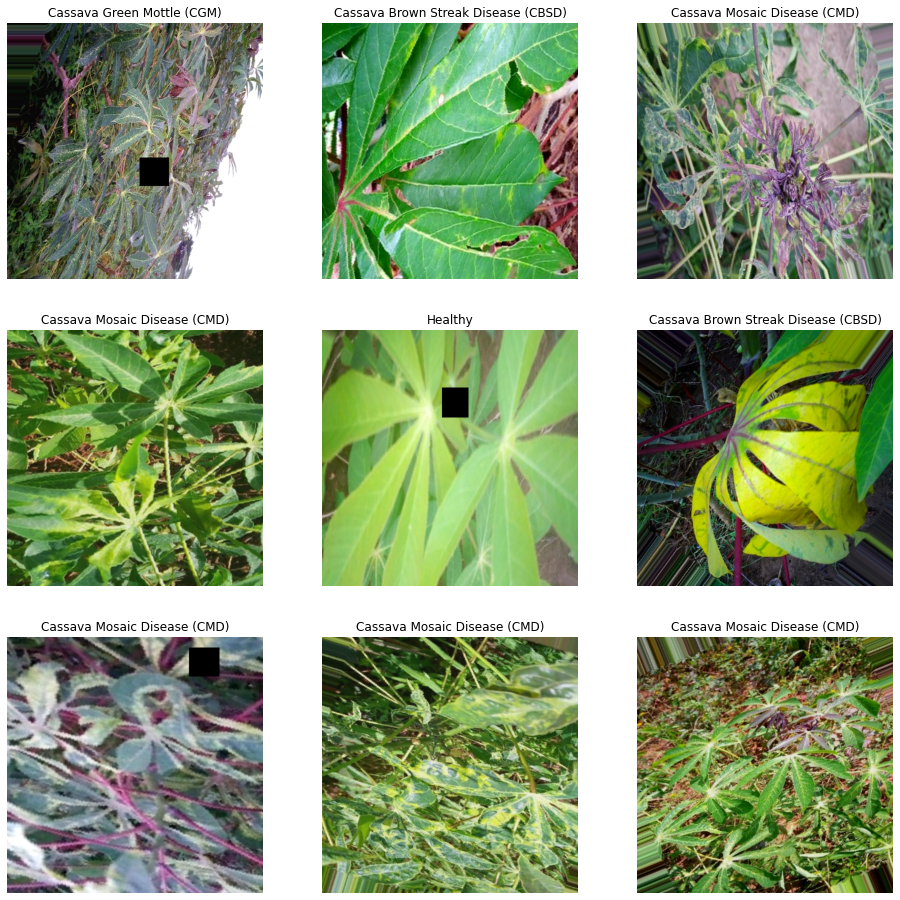

In [35]:
show_images(train_ds
            .unbatch()
            .map(scale_image, num_parallel_calls=AUTOTUNE))

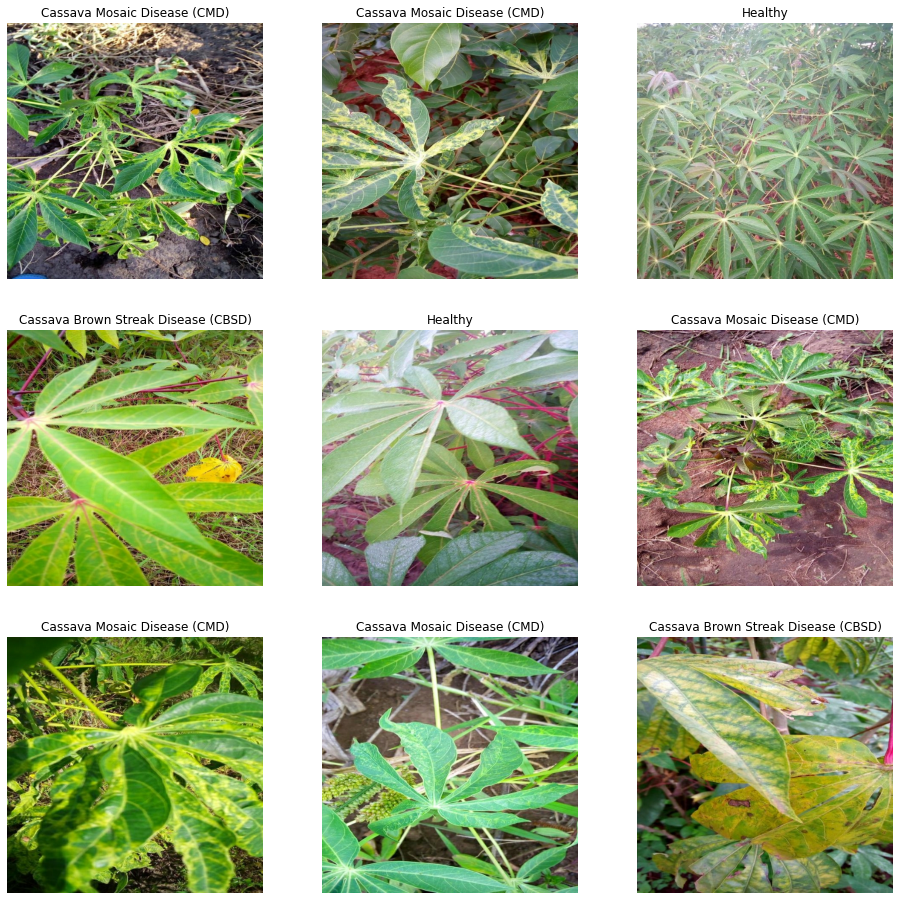

In [36]:
show_images(valid_ds
            .unbatch()
            .map(scale_image, num_parallel_calls=AUTOTUNE))

# Model



## Batch augmentation

In [37]:
def create_batch_augment():
    return tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomCrop(HEIGHT, WIDTH),
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.25),
        tf.keras.layers.experimental.preprocessing.RandomZoom((-0.2, 0)),
        tf.keras.layers.experimental.preprocessing.RandomContrast((0.2,0.2))])

In [38]:
batch_augment = create_batch_augment()
func = lambda x,y: (batch_augment(x), y)
x = (train_ds
     .map(scale_image, num_parallel_calls=AUTOTUNE)
     .map(func, num_parallel_calls=AUTOTUNE))

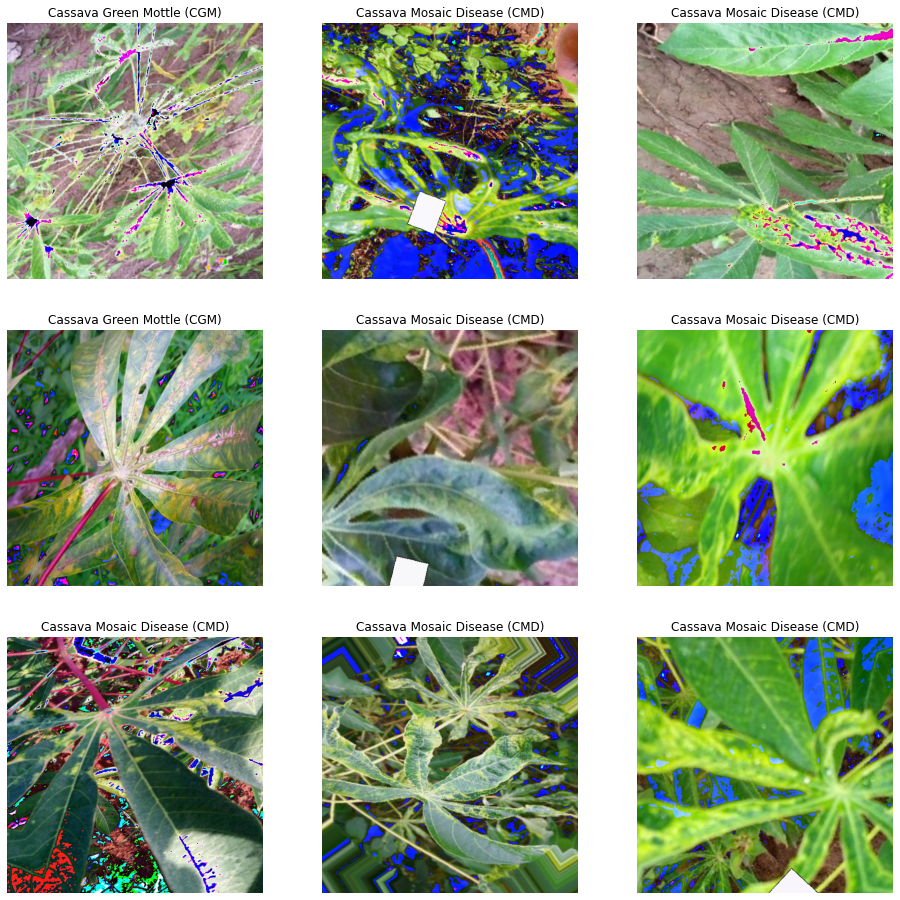

In [39]:
show_images(x.unbatch())

## Building a model

I am using an EfficientNetB3 on top of which I add some output layers to predict our 5 disease classes. I decided to load the imagenet pretrained weights locally to keep the internet off (part of the requirements to submit a kernal to this competition).

In [40]:
#hide
%%run_if {KAGGLE}
import subprocess
subprocess.check_call([sys.executable, '-m', 'pip', 'install','-q', '/kaggle/input/kerasapplications'])
subprocess.check_call([sys.executable, '-m', 'pip', 'install','-q', '/kaggle/input/efficientnet-git'])
import efficientnet.tfkeras as efn

In [41]:
%%run_if {GOOGLE}
import tensorflow.keras.applications as efn

In [42]:
def unfreeze_model(model):
    # Unfreeze layers while leaving BatchNorm layers frozen
    for layer in model.layers:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False
            
def unfreeze_block(model, block_name=None, n_top=3):
    # Unfreeze layers while leaving BatchNorm layers frozen
    for layer in model.layers[:-n_top]:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False
        else:
            if block_name and (block_name in layer.name):
                layer.trainable = True

In [43]:
def create_model(input_shape, num_classes):
    inputs = tf.keras.layers.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB4(input_tensor=inputs, 
                                    include_top=False, 
                                    weights='imagenet' if TRAIN else None, 
                                    pooling='avg')
    base_model.trainable = False
    x = tf.keras.layers.Dropout(.5)(base_model.output)
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    output = tf.keras.layers.Dense(num_classes, activation='relu', name='output')(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=output)
    return model

## Optimizer : CosineDecay

> Important: I always wanted to try the new `CosineDecayRestarts` function implemented in `tf.keras` as it seemed promising and I struggled to find the right settings (if there were any) for the `ReduceLROnPlateau`

> Warning: There is a gap between what I had expected and the acutal `LearningRateScheduler` that tensorflow gives us. The `LearningRateScheduler` update the lr `on_epoch_begin` while it makes more sense to do it `on_batch_end` or `on_batch_begin`.

In [44]:
class CustomCyclicSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, n_step, lr_max, div=25.0, div_final=1e5,
                 pct_start=0.25, staircase=False, cycle=False):
        self.lr_start = lr_max / div
        self.lr_max = lr_max
        self.lr_min = lr_max / div_final
        self.rising_steps = int(n_step * pct_start)
        self.rising_a = (lr_max-self.lr_min) / (self.rising_steps-1)
        self.rising_b = self.lr_min

        self.falling_steps = int(n_step - self.rising_steps)
        self.falling_rate = self.lr_min / lr_max
        self.cycle = tf.constant(cycle, dtype=tf.bool)
        self.decay_fn = tf.keras.experimental.CosineDecay(
            initial_learning_rate = lr_max,
            decay_steps = self.falling_steps,
            alpha = self.lr_min)

    def __call__(self, step):
        """ `step` is actually the step index, starting at 0. """
        lr = tf.cond(step < self.rising_steps,
                     lambda : self.rising_a*tf.cast(step, tf.float32) + self.rising_b,
                     lambda : self.decay_fn(tf.cast(step-self.rising_steps, tf.int32)))
        return tf.cast(lr, tf.float32)

In [45]:
%%run_if {TRAIN}
#@title { run: "auto", display-mode: "form" }
#STEPS = (count_data_items(train_filenames) // GLOBAL_BATCH_SIZE) * EPOCHS
#LR_START = 9e-3 #@param {type: "number"}
#LR_START *= strategy.num_replicas_in_sync
#LR_MIN = 3e-4 #@param {type: "number"}
#N_RESTARTS =  5#@param {type: "number"}
#T_MUL = 2.0 #@param {type: "number"}
#M_MUL =  1#@param {type: "number"}
#STEPS_START = math.ceil((T_MUL-1)/(T_MUL**(N_RESTARTS+1)-1) * STEPS)
#
#with strategy.scope():
#    schedule = tf.keras.experimental.CosineDecayRestarts(
#        first_decay_steps=STEPS_START,
#        initial_learning_rate=LR_START,
#        alpha=LR_MIN,
#        m_mul=M_MUL,
#        t_mul=T_MUL)
#
#xps = tf.range(STEPS)
#yps = [schedule(x) for x in xps]
#
#_,ax = plt.subplots(1,1,figsize=(8,5),facecolor='#F0F0F0')
#ax.plot(xps, yps)
#ax.set_facecolor('#F8F8F8')
#ax.set_xlabel('iteration')
#ax.set_ylabel('learning rate')
#
#print('{:d} total epochs and {:d} steps per epoch'
#        .format(EPOCHS, STEPS // EPOCHS))

NSTEPS = (count_data_items(train_filenames) / GLOBAL_BATCH_SIZE) * EPOCHS
LR_MAX = 1e-4 #@param {type: "number"}
LR_MAX *= strategy.num_replicas_in_sync
DIV = 25.0 #@param {type: "number"}
DIV_FINAL = 1e5 #@param {type: "number"}
PCT_START = 0.25#@param {type: "number"}

with strategy.scope():
    schedule = CustomCyclicSchedule(
        n_step=NSTEPS,
        lr_max=LR_MAX,
        div=DIV,
        div_final=DIV_FINAL,
        cycle=False)

#xps = tf.range(NSTEPS)
#yps = [schedule(x) for x in xps]
#fig,ax = plt.subplots(1,1,figsize=(8,5),facecolor='#F0F0F0')
#ax.plot(xps, yps)
#ax.set_facecolor('#F8F8F8')
#ax.set_xlabel('iteration')
#ax.set_ylabel('learning rate')
#
#print('{} total epochs and {} steps per epoch'
#        .format(int(EPOCHS), NSTEPS // EPOCHS))

## Callbacks

### LR finder

In [ ]:
#collapse-show
%%run_if {GOOGLE and TRAIN}
from tensorflow.keras.callbacks import Callback
class LRFinder(Callback):
    """`Callback` that exponentially adjusts the learning rate after
    each training batch between `start_lr` and `end_lr` for a maximum number
    of batches: `max_step`. The loss and learning rate are recorded at each
    step allowing visually finding a good learning rate as
    https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html suggested.
    """

    def __init__(self, start_lr: float = 1e-7, end_lr: float = 10,
                 max_steps: int = 100, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self, skip_end=None):
        lrs = self.lrs[:-skip_end] if skip_end else self.lrs[:-5]
        losses = self.losses[:-skip_end] if skip_end else self.losses[:-5]
        fig, ax = plt.subplots(1, 1, facecolor="#F0F0F0")
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(lrs, losses)

In [ ]:
%%run_if {GOOGLE and TRAIN}
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
lr_finder = LRFinder()
_ = model.fit(train_ds_batch, epochs=1, callbacks=[lr_finder])

In [ ]:
%%run_if {GOOGLE and TRAIN}
lr_finder.plot(skip_end=20)

As can be observed from the curve, we can pinpoint the `lr_max` to be `9e-3` and the `lr_min` to be `3e-4`. Let's feed these hyperparams back to the optimizer schedule and retrain the model.

Before retraining, don't forget to reset the model so it can be trained from the `000_normalization.h5` rather than 1 epoch after it because executing the `lr_finder`

> Tip: I will create a repo, `tflearner` and have this implemented as a `.reset` method of a `learner` class.

In [ ]:
%%run_if {GOOGLE and TRAIN}
efficientnet = EfficientNetB3(
    weights = 'imagenet', 
    include_top = False, 
    input_shape = IMG_SIZE, 
    pooling='avg')
efficientnet.trainable = True
model = build_model(base_model=efficientnet, num_class=len(id2label))
model.load_weights("000_normalization.h5")

### Others

In [ ]:
%%run_if {TRAIN}
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='001_best_model.h5',
        monitor='val_loss',
        save_best_only=True),
    ]

In [ ]:
%%run_if {TRAIN}
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(schedule),
              metrics=["accuracy"])

## Custom Training

In [46]:
def get_metrics(name):
    loss = tf.keras.metrics.Mean(name=f'{name}_loss', dtype=tf.float32)
    acc = tf.keras.metrics.SparseCategoricalAccuracy(name=f'{name}_acc', dtype=tf.float32)
    return loss, acc

In [47]:
with strategy.scope():
    model = create_model((None, None, CHANNELS), NCLASSES)
    # unfreeze all layers except "batch normalization"
    unfreeze_model(model)
    loss_function = tf.keras.losses.categorical_crossentropy
    opt = tf.keras.optimizers.Adam(schedule)
    train_loss_obj, train_acc_obj = get_metrics('train')
    valid_loss_obj, valid_acc_obj = get_metrics('valid')

In [48]:
N_TRAIN_STEPS = count_data_items(train_filenames) // GLOBAL_BATCH_SIZE
N_VALID_STEPS = count_data_items(valid_filenames) // GLOBAL_BATCH_SIZE
N_TOTAL_STEPS = N_TRAIN_STEPS + N_VALID_STEPS

In [49]:
del train_ds; del valid_ds; import gc; gc.collect()

2369

In [50]:
train_ds = get_train_dataset(train_filenames)
valid_ds = get_valid_dataset(valid_filenames)

train_dist_ds = strategy.experimental_distribute_dataset(train_ds)
valid_dist_ds = strategy.experimental_distribute_dataset(valid_ds)

In [51]:
train_input_signature = [
    tf.TensorSpec(shape=(None, None, None, None), dtype=tf.float32),
    tf.TensorSpec(shape=(None, None), dtype=tf.float32)
]

@tf.function(input_signature=train_input_signature)
def train_step(images, labels):
    with tf.GradientTape() as tape:
        probs = model(images, training=True)
        loss = loss_function(labels, probs)

    grads = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    train_acc_obj(labels, probs)
    return loss

@tf.function
def distributed_train_step(inputs):
    (images, labels) = inputs
    per_replica_losses = strategy.run(train_step, args=(images, labels))
    return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)

In [52]:
images, labels = next(iter(train_dist_ds))

In [53]:
with tf.GradientTape() as tape:
    probs = model(images.values[0], training=True)
    loss = loss_function(labels.values[0], probs)

In [54]:
grads = tape.gradient(loss, model.trainable_variables)

In [55]:
opt.apply_gradients(zip(grads, model.trainable_variables))

ValueError: ignored

In [ ]:
metrics_names = ['train_loss','train_acc'] 
pbar = tf.keras.utils.Progbar(10, width=15, stateful_metrics=metrics_names)

train_loss_obj.reset_states()
train_acc_obj.reset_states()
train_iter = iter(train_dist_ds)

for i,train_inputs in enumerate(train_dist_ds):
    if i == 10: break
    train_loss = distributed_train_step(train_inputs)
    train_loss_obj(train_loss)
    values=[('train_loss', train_loss_obj.result()),
            ('train_acc', train_acc_obj.result())]
    pbar.add(1, values=values)

In [ ]:
valid_input_signature = train_input_signature

@tf.function(input_signature=valid_input_signature)
def valid_step(images, labels):
    prob_dists = model(images, training=False)
    loss = loss_function(labels, prob_dists, sample_weights=None)
    valid_acc_obj(labels, prob_dists)
    return loss, prob_dists

@tf.function
def distributed_valid_step(inputs):
    (images, labels) = inputs
    losses, prob_dists = strategy.run(valid_step, args=(images, labels))
    return strategy.reduce(tf.distribute.ReduceOp.SUM, losses, axis=None), prob_dists

In [ ]:
for fold,(idxT, idxV) in enumerate(skf.split(np.arange(50))):
    
    np.random.shuffle(TRAIN_FILENAMES)
    
    ct_train = count_data_items(TRAIN_FILENAMES)
    ct_valid = count_data_items(VALID_FILENAMES)
    
    step_size = (ct_train // BATCH_SIZE)
    valid_step_size = (ct_valid // BATCH_SIZE)
    total_steps=(total_epochs * step_size)
    warmup_steps=(warmup_epochs * step_size)
    
    # Build TF datasets
    train_ds = strategy.experimental_distribute_dataset(get_dataset(TRAIN_FILENAMES, repeated=True, augment=True))
    valid_ds = strategy.experimental_distribute_dataset(get_dataset(VALID_FILENAMES, ordered=True, repeated=True, cached=True))
    train_data_iter = iter(train_ds)
    valid_data_iter = iter(valid_ds)
    
    # Step functions
    @tf.function
    def train_step(data_iter):
        def train_step_fn(x, y):
            with tf.GradientTape() as tape:
                probabilities = model(x, training=True)
                loss = loss_fn(y, probabilities, label_smoothing=.3)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            # update metrics
            train_accuracy.update_state(y, probabilities)
            train_loss.update_state(loss)
        for _ in tf.range(step_size):
            strategy.experimental_run_v2(train_step_fn, next(data_iter))

    @tf.function
    def valid_step(data_iter):
        def valid_step_fn(x, y):
            probabilities = model(x, training=False)
            loss = loss_fn(y, probabilities)
            # update metrics
            valid_accuracy.update_state(y, probabilities)
            valid_loss.update_state(loss)
        for _ in tf.range(valid_step_size):
            strategy.experimental_run_v2(valid_step_fn, next(data_iter))
    
    
    # Model
    model_path = f'model_{fold}.h5'
    with strategy.scope():
        model = model_fn((None, None, CHANNELS), N_CLASSES)
        unfreeze_model(model) # unfreeze all layers except "batch normalization"
        
        optimizer = optimizers.Adam(learning_rate=lambda: lrfn(tf.cast(optimizer.iterations, tf.float32)))
        loss_fn = losses.categorical_crossentropy

        train_accuracy = metrics.CategoricalAccuracy()
        valid_accuracy = metrics.CategoricalAccuracy()
        train_loss = metrics.Sum()
        valid_loss = metrics.Sum()
    
    
    # Setup training loop
    step = 0
    epoch_steps = 0
    patience_cnt = 0
    best_val = 0
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

    ### Train model
    for epoch in range(EPOCHS):
        epoch_start_time = time.time()

        # Run training step
        train_step(train_data_iter)
        epoch_steps += step_size
        step += step_size
            

        # Validation run at the end of each epoch
        if (step // step_size) > epoch:
            # Validation run
            valid_epoch_steps = 0
            valid_step(valid_data_iter)
            valid_epoch_steps += valid_step_size

            # Compute metrics
            history['accuracy'].append(train_accuracy.result().numpy())
            history['loss'].append(train_loss.result().numpy() / (BATCH_SIZE * epoch_steps))
            history['val_accuracy'].append(valid_accuracy.result().numpy())
            history['val_loss'].append(valid_loss.result().numpy() / (BATCH_SIZE * valid_epoch_steps))

            # Report metrics
            epoch_time = time.time() - epoch_start_time
            print(f'\nEPOCH {epoch+1}/{EPOCHS}')
            print(f'time: {epoch_time:0.1f}s',
                  f"loss: {history['loss'][-1]:0.4f}",
                  f"accuracy: {history['accuracy'][-1]:0.4f}",
                  f"val_loss: {history['val_loss'][-1]:0.4f}",
                  f"val_accuracy: {history['val_accuracy'][-1]:0.4f}",
                  f'lr: {lrfn(tf.cast(optimizer.iterations, tf.int32).numpy()):0.4g}')

            # Early stopping monitor
            if history['val_accuracy'][-1] >= best_val:
                best_val = history['val_accuracy'][-1]
                model.save_weights(model_path)
                print(f'Saved model weights at "{model_path}"')
                patience_cnt = 1
            else:
                patience_cnt += 1
            if patience_cnt > ES_PATIENCE:
                print(f'Epoch {epoch:05d}: early stopping')
                break

                
            # Set up next epoch
            epoch = step // step_size
            epoch_steps = 0
            train_accuracy.reset_states()
            train_loss.reset_states()
            valid_accuracy.reset_states()
            valid_loss.reset_states()
    
    
    ### RESULTS
    print(f"#### FOLD {fold+1} OOF Accuracy = {np.max(history['val_accuracy']):.3f}")
    
    history_list.append(history)
    # Load best model weights
    model.load_weights(model_path)

    # OOF predictions
    ds_valid = get_dataset(VALID_FILENAMES, ordered=True)
    oof_labels.append([target.numpy() for img, target in iter(ds_valid.unbatch())])
    x_oof = ds_valid.map(lambda image, target: image)
    oof_pred.append(np.argmax(model.predict(x_oof), axis=-1))

## Evaluating


In [ ]:
def show_history(history):
    topics = ['loss', 'accuracy']
    groups = [{k:v for (k,v) in history.items() if topic in k} for topic in topics]
    _,axs = plt.subplots(1,2,figsize=(15,6),facecolor='#F0F0F0')
    for topic,group,ax in zip(topics,groups,axs.flatten()):
        for (_,v) in group.items(): ax.plot(v)
        ax.set_facecolor('#F8F8F8')
        ax.set_title(f'{topic} over epochs')
        ax.set_xlabel('epoch')
        ax.set_ylabel(topic)
        ax.legend(['train', 'valid'], loc='best')

In [ ]:
%%run_if {TRAIN}
show_history(history.history)

We load the best weight that were kept from the training phase. Just to check how our model is performing, we will attempt predictions over the validation set. This can help to highlight any classes that will be consistently miscategorised.

In [ ]:
model.load_weights('{}001_best_model.h5'.format(
    '' if TRAIN else '../input/cassava-leaf-disease-classification-models/'))

## Prediction

In [ ]:
x = train_df.sample(1).filename.values[0]
img = decode_image(x)

CPU times: user 61.7 ms, sys: 20 µs, total: 61.7 ms
Wall time: 60.5 ms


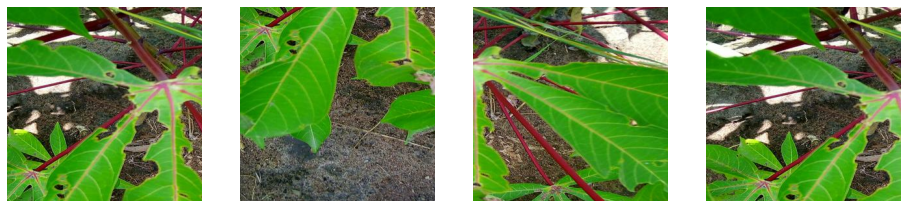

In [ ]:
%%time
imgs = [tf.image.random_crop(img, size=IMG_SIZE) for _ in range(4)]

_,axs = plt.subplots(1,4,figsize=(16,4))
for (x, ax) in zip(imgs, axs.flatten()):
    ax.imshow(x.numpy().astype(np.uint8))
    ax.axis('off')

I apply some very basic test time augmentation to every local image extracted from the original 600-by-800 images. We know we can do some fancy augmentation with `albumentations` but I wanted to do that exclusively with Keras preprocessing layers to keep the cleanest pipeline possible.

In [ ]:
tta = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomCrop(HEIGHT, WIDTH),
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomZoom((-0.2, 0.2)),
        tf.keras.layers.experimental.preprocessing.RandomContrast((0.2,0.2))
    ]
)

In [ ]:
def predict_tta(filename, num_tta=4):
    img = decode_image(filename)
    img = tf.expand_dims(img, 0)
    imgs = tf.concat([tta(img) for _ in range(num_tta)], 0)
    preds = model.predict(imgs)
    return preds.sum(0).argmax()

In [ ]:
pred = predict_tta(df.sample(1).filename.values[0])
print(pred)

In [ ]:
from tqdm import tqdm
preds = []
with tqdm(total=len(valid_df)) as pbar:
    for filename in valid_df.filename:
        pbar.update()
        preds.append(predict_tta(filename, num_tta=4))

In [ ]:
cm = tf.math.confusion_matrix(valid_df.label.values, np.array(preds))
plt.figure(figsize=(10, 8))
sns.heatmap(cm,
            xticklabels=id2label.values(),
            yticklabels=id2label.values(), 
            annot=True,
            fmt='g',
            cmap="Blues")
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
test_folder = input_path + '/test_images/'
submission_df = pd.DataFrame(columns={"image_id","label"})
submission_df["image_id"] = os.listdir(test_folder)
submission_df["label"] = 0

In [ ]:
submission_df['label'] = (submission_df['image_id']
                            .map(lambda x : predict_tta(test_folder+x)))

In [ ]:
submission_df

In [ ]:
submission_df.to_csv("submission.csv", index=False)